In [1]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11986879297795574936
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4162846720
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17211705140049518267
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


### LSTM(Long Short Term Memory) Implementation

#### 1. Model and Parameter Setting

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

#### 2. Train Data

In [7]:
DATA_IN_PATH = './Text_Classification/data_in/'
DATA_OUT_PATH = './Text_Classification/data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [8]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r', encoding='cp949'))

### 3. Define Model Hyperparameter

In [9]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128 # 128개의 sample의 loss function을 받아 평균을 가중치에 update
NUM_EPOCHS = 5 # 전체 smaple을 5번 반복 학습
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
         'vocab_size' : prepro_configs['vocab_size'],
         'embedding_dimension' : 100,
         'dropout_rate' : 0.2,
         'lstm_dimension' : 150,
         'dense_dimension' : 150,
         'output_dimension' : 1}

#### 4. Model Implementation

In [14]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                          output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                                activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation=tf.keras.activations.sigmoid)
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

#### 5. Generate Model

In [17]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

#### 6. Training the Model

In [18]:
# EarlyStopping
# overfitting을 막기 위한 earlystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=1)

# monitor='val_accuracy' : 성능 평가 지표로 val_accuracy
# min_delta : val_accuracy 가 낮아져야 성능이 좋아지는 것이지만 낮아지는 폭이 1e-4보다 작아지면 정지
# min_delta : the threashold that triggers the termination (accuracy should at least improve 1e-4)
# patience : no improvement epochs (patience = 1 : 1번 이상 상승이 없으면 종료)

In [20]:
# ModelCheckpoint
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if not exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

./Text_Classification/data_out/rnn_classifier_en -- Folder create complete 



In [21]:
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

In [22]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - 16s 62ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5096

Epoch 00001: val_accuracy improved from -inf to 0.50960, saving model to ./Text_Classification/data_out/rnn_classifier_en\weights.h5
Epoch 2/5
176/176 [==============================] - 10s 57ms/step - loss: 0.6805 - accuracy: 0.5345 - val_loss: 0.4860 - val_accuracy: 0.7576

Epoch 00002: val_accuracy improved from 0.50960 to 0.75760, saving model to ./Text_Classification/data_out/rnn_classifier_en\weights.h5
Epoch 3/5
176/176 [==============================] - 10s 58ms/step - loss: 0.3408 - accuracy: 0.8566 - val_loss: 0.2773 - val_accuracy: 0.8844

Epoch 00003: val_accuracy improved from 0.75760 to 0.88440, saving model to ./Text_Classification/data_out/rnn_classifier_en\weights.h5
Epoch 4/5
176/176 [==============================] - 10s 58ms/step - loss: 0.1876 - accuracy: 0.9304 - val_loss: 0.2784 - val_accuracy: 0.8888

Epoch 00004: val_ac

#### 7. Visualize with Graph

In [23]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

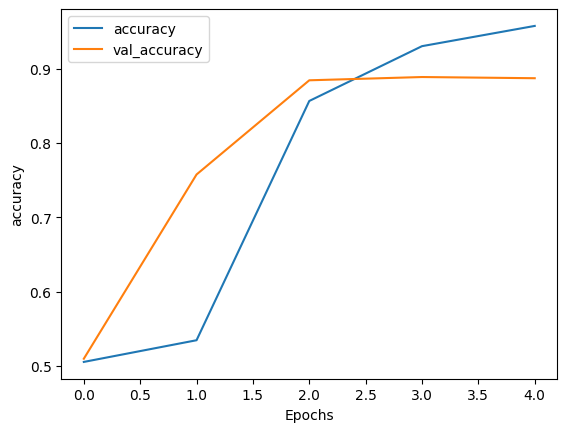

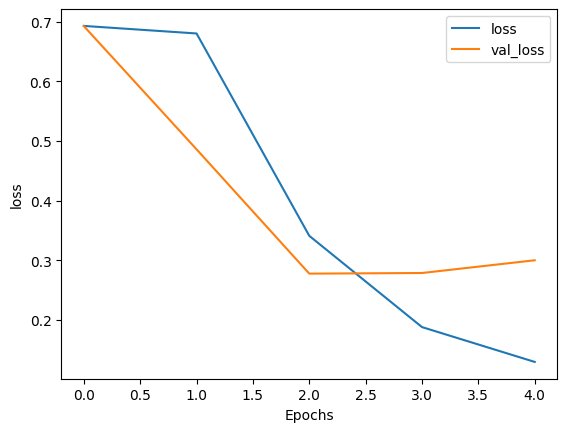

In [24]:
plot_graphs(history, 'accuracy')

plot_graphs(history, 'loss')

#### 8. Submit the data

In [25]:
DATA_OUT_PATH = './Text_Classification/data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))

In [26]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [27]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [28]:
predictions.shape

(25000,)

In [30]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={'id':list(test_id), 'sentiment':list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3)